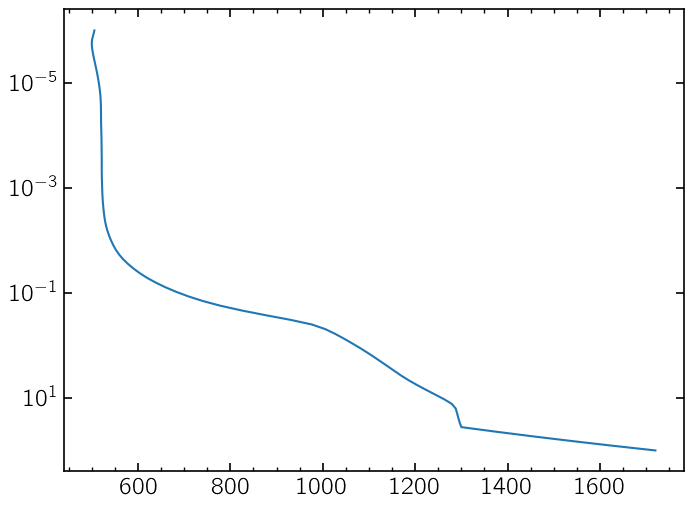

In [1]:
directory = '/Volumes/Oy/ReflectX/ReflectXGasGiantModelGrid-V1/'
directory += "ReflectXGasGiantModelGrid-Jupiter-Tstar5000-Rstar0.8-Teq624-sep0.1-rad1.0-mass1.0-mh3-co0.5-phase120"
m = pickle.load(open(directory + '/cloud-free-model.pkl','rb'))[1]
%matplotlib inline
plt.plot(m['temperature'],m['pressure'])
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')

In [2]:
from myastrotools.reflectx import GetP, GetDirectoryLocInP
directory = "ReflectXGasGiantModelGrid-Jupiter-Tstar5000-Rstar0.8-Teq624-sep0.1-rad1.0-mass1.0-mh3-co0.5-phase120"
p = GetP()
loc = GetDirectoryLocInP(p,directory)
loc+2

408

# Test 1: setting pbottom to log10(300)

/Volumes/Oy/picaso/reference/kcoeff_2020/sonora_2020_feh+050_co_050_noTiOVO.data.196
NOTE: You are loading Opacity tables without any Gaseous TiO and VO opacities
starting climate run
Iteration number  0 , min , max temp  536.5147729647068 1420.440996269638 , flux balance  -247.19836241525192
Iteration number  1 , min , max temp  534.3041255712141 1574.8706993997878 , flux balance  -219.56960977973654
Iteration number  2 , min , max temp  526.8962516312674 1793.8434029239445 , flux balance  -110.08763677764892
Iteration number  3 , min , max temp  513.0473059732625 1879.4512979277954 , flux balance  33.64099884937269
Iteration number  4 , min , max temp  512.3104264379092 1868.1881503629318 , flux balance  0.9044909924862803
Iteration number  5 , min , max temp  512.3072229755883 1867.9538645556481 , flux balance  0.0010893652017299781
In t_start: Converged Solution in iterations  5
Big iteration is  512.3072229755883 0
Iteration number  0 , min , max temp  503.9564998798262 1816.36451

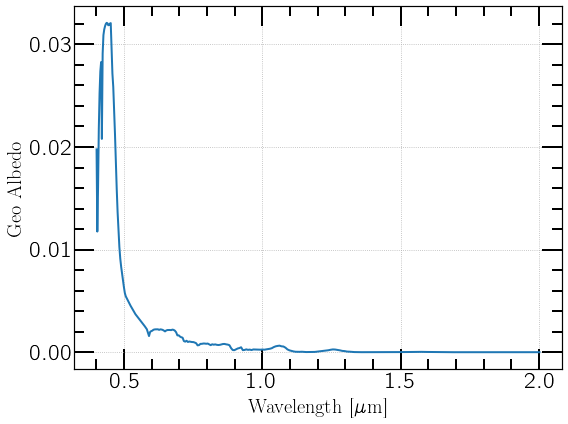

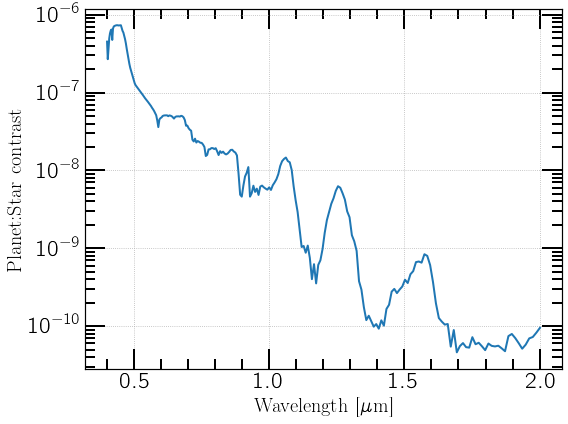

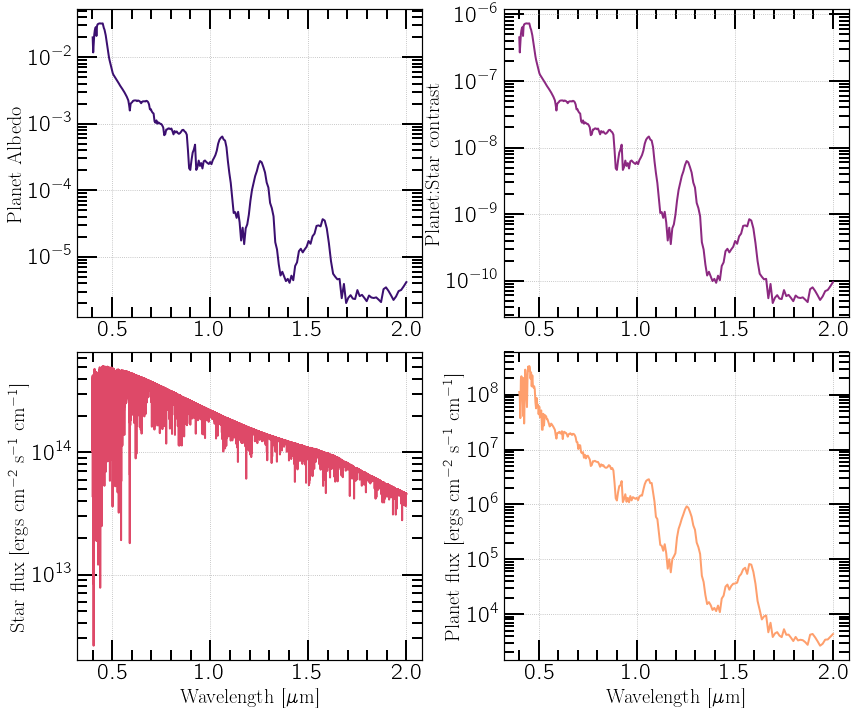

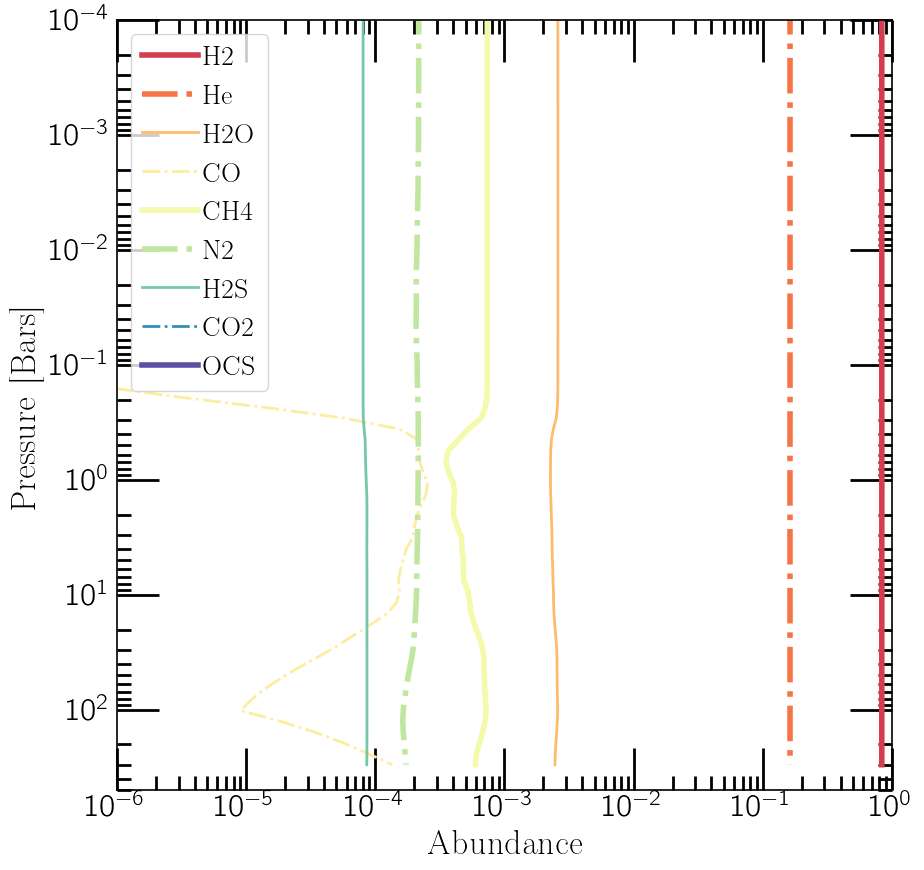

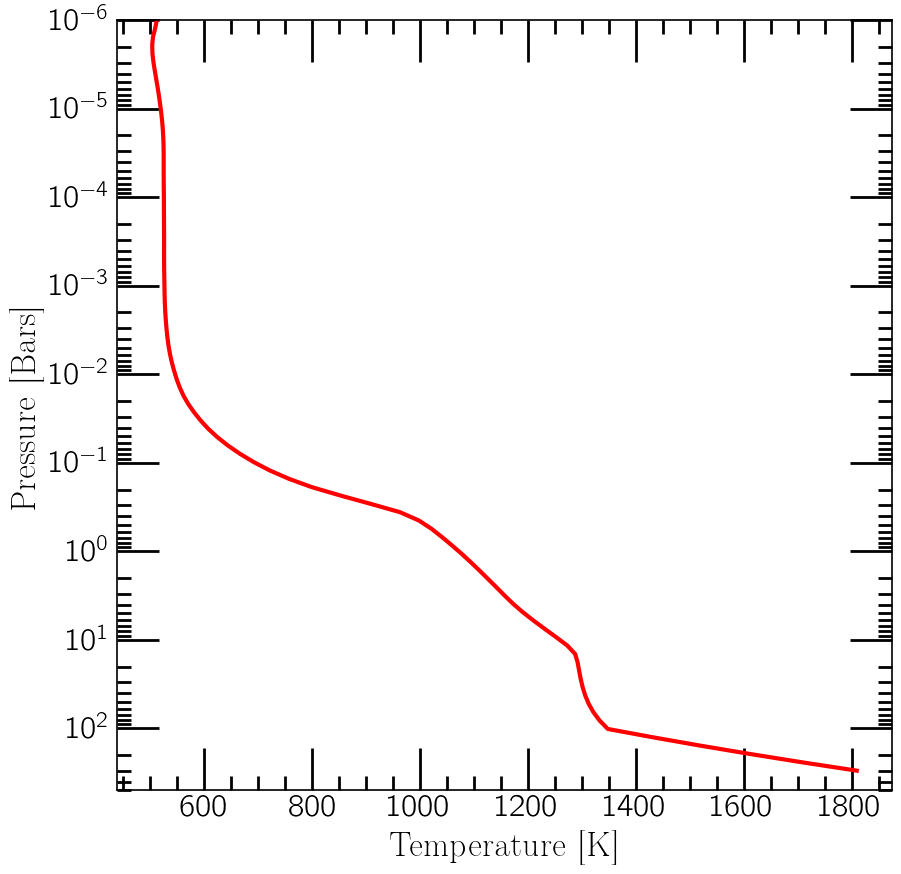

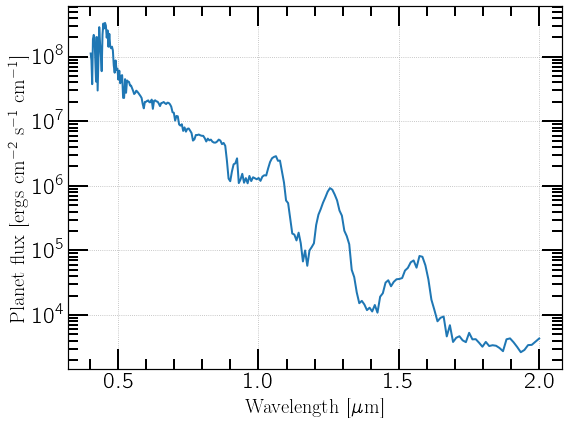

In [3]:
import numpy as np
#from tools.tools import *
from myastrotools.reflectx import *
import astropy.units as u
import pandas as pandas

def Run1Model(p, num_tangle = 6, num_gangle = 6):
    import time
    start = time.time()

    grid = p['name']
    ## Planet:
    planettype = p['planet_type']
    Tint = p['tint'] # Internal Temperature of your Planet in K
    Teq = ComputeTeq(p['st_teff'], p['rstar']*u.Rsun, p['au']*u.au, 
                     Ab = 0.3, fprime = 1/4) # planet equilibrium temperature 
    radius = p['pl_rad'] #Rjup
    massj = p['pl_mass']
    semi_major = p['au']
    phase = p['phase']

    ## Star:
    T_star = p['st_teff'] # K, star effective temperature
    logg = p['logg'] #logg , cgs
    metal = p['feh'] # metallicity of star
    r_star = p['rstar'] # solar radius


    ## Climate:
    nlevel = int(p['nlevel']) # number of plane-parallel levels in your code
    nofczns = int(p['nofczns']) # number of convective zones initially. Let's not play with this for now.
    nstr_upper = int(p['nstr_upper']) # top most level of guessed convective zone
    nstr_deep = nlevel -2 # this is always the case. Dont change this
    nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones
    rfacv = p['rfacv']

    ## Opacities:
    #
    planet_mh = p['mh']
    planet_mh_CtoO = p['cto']

    Teq_str = np.round(Teq, decimals=0)
    directory = f'{grid}-{planettype}-Tstar{int(T_star)}-Rstar{r_star}-Teq{int(Teq_str)}-sep{semi_major}-rad{radius}-mass{massj}-mh{int(planet_mh)}-co{planet_mh_CtoO}-phase{int(phase)}-Test1'
    #savefiledirectory = p['output_dir']+directory
    output_dir = ''
    savefiledirectory = output_dir+directory

    local_ck_path = f'/Volumes/Oy/picaso/reference/kcoeff_2020/'
    #local_ck_path = p['local_ck_path']

    planet_properties = {
        'tint':Tint, 'Teq':Teq, 'radius':radius, 'radius_unit':u.Rjup,
         'mass':massj, 'mass_unit': u.Mjup,
         'gravity': None, 'gravity_unit':None,
        'semi_major':semi_major, 'semi_major_unit': u.AU,
        'mh': planet_mh, 'CtoO':planet_mh_CtoO, 'phase':phase, 'num_tangle':num_tangle,
        'num_gangle':num_gangle, 'noTiOVO':p['noTiOVO'], 'planet_mh_str':p['mh_str'],
        'local_ck_path':local_ck_path
    }

    star_properties = {
        'Teff':T_star, 'logg':logg, 'mh':metal, 'radius':r_star
    }

    climate_run_setup = {'climate_pbottom':np.log10(300),
            'climate_ptop':int(p['p_top']),
            'nlevel':nlevel, 'nofczns':nofczns, 'nstr_upper':nstr_upper,
            'nstr_deep':nstr_deep, 'rfacv':rfacv
    }
    #opa_file = p['opa_file']
    opa_file = None
    wave_range = [float(p['wave_range'].split(',')[0].replace('[','')),
              float(p['wave_range'].split(',')[1].replace(' ','').replace(']',''))]
    spectrum_setup = {'opacity_db':opa_file,
                      'wave_range':wave_range,
                      'calculation':'reflected', 'R':150
                     }

    if p['guess'] == 'guillot':
        use_guillotpt = True


    cj = MakeModelCloudFreePlanet(planet_properties, 
                            star_properties,
                            use_guillotpt = True,
                            cdict = climate_run_setup,
                            compute_spectrum = True,
                            specdict = spectrum_setup,
                            savefiledirectory = savefiledirectory, 
                            record_terminal_output = False
                 )
    stop = time.time()
    runtime = stop - start
    print('Runtime: ',runtime,' sec, ', runtime*u.s.to(u.min),' min')
#     with open(savefiledirectory+'/terminal_output.txt','r') as f:
#         z = f.read()
#         k = open('ReflectXGasGiantRunReport.txt','a')
#         t = time.localtime()
#         outtime = str(t.tm_year)+'-'+str(t.tm_mon)+'-'+str(t.tm_mday)+'-'+str(t.tm_hour)+':'+str(t.tm_min)+':'+str(t.tm_sec)
#         if 'YAY ! ENDING WITH CONVERGENCE' in z:
#             k.write(savefiledirectory + ' ' +outtime + '  converged \n')
#         else:
#             k.write(savefiledirectory + ' ' +outtime + '  FAILED \n')
#         k.close()
        
    return savefiledirectory, cj


def GetP(sheet_id='11u2eirdZcWZdjnKFn3vzqbCtKCodstP-KnoGXC5FdR8', 
             sheet_name='GasGiantsBaseModels'):
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&gid={sheet_name}"
    p = pd.read_csv(url)
    p = p.dropna(axis=1, how='all')
    for i in range(len(p)):
        try:
            if np.isnan(p[p.columns[0]][0]):
                p = p.drop(i, axis=0)
        except TypeError:
            pass
    return p


def RunGrid(sheet_id='11u2eirdZcWZdjnKFn3vzqbCtKCodstP-KnoGXC5FdR8', 
             sheet_name='GasGiantsBaseModels', n_jobs = 3):
    #k = open('ReflectXGasGiantRunReport.txt','w')
    #k.close()
    p = GetP(sheet_id=sheet_id, 
             sheet_name=sheet_name)
    p = p.loc[loc]
#     import picaso.justdoit as jdi
#     jdi.Parallel(n_jobs=n_jobs)(jdi.delayed(Run1Model)(p.loc[i]) for i in range(len(p)))
    Run1Model(p)



RunGrid()

# Test 2: run with chemi diseq Kzz hack

In [ ]:
import numpy as np
#from tools.tools import *
from myastrotools.reflectx import *
import astropy.units as u
import pandas as pandas

def Run1Model(p, num_tangle = 6, num_gangle = 6):
    import time
    start = time.time()

    grid = p['name']
    ## Planet:
    planettype = p['planet_type']
    Tint = p['tint'] # Internal Temperature of your Planet in K
    Teq = ComputeTeq(p['st_teff'], p['rstar']*u.Rsun, p['au']*u.au, 
                     Ab = 0.3, fprime = 1/4) # planet equilibrium temperature 
    radius = p['pl_rad'] #Rjup
    massj = p['pl_mass']
    semi_major = p['au']
    phase = p['phase']

    ## Star:
    T_star = p['st_teff'] # K, star effective temperature
    logg = p['logg'] #logg , cgs
    metal = p['feh'] # metallicity of star
    r_star = p['rstar'] # solar radius


    ## Climate:
    nlevel = int(p['nlevel']) # number of plane-parallel levels in your code
    nofczns = int(p['nofczns']) # number of convective zones initially. Let's not play with this for now.
    nstr_upper = int(p['nstr_upper']) # top most level of guessed convective zone
    nstr_deep = nlevel -2 # this is always the case. Dont change this
    nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones
    rfacv = p['rfacv']

    ## Opacities:
    #
    planet_mh = p['mh']
    planet_mh_CtoO = p['cto']

    Teq_str = np.round(Teq, decimals=0)
    directory = f'{grid}-{planettype}-Tstar{int(T_star)}-Rstar{r_star}-Teq{int(Teq_str)}-sep{semi_major}-rad{radius}-mass{massj}-mh{int(planet_mh)}-co{planet_mh_CtoO}-phase{int(phase)}-Test2'
    #savefiledirectory = p['output_dir']+directory
    output_dir = ''
    savefiledirectory = output_dir+directory

    local_ck_path = f'/Volumes/Oy/picaso/reference/kcoeff_2020/'
    #local_ck_path = p['local_ck_path']

    planet_properties = {
        'tint':Tint, 'Teq':Teq, 'radius':radius, 'radius_unit':u.Rjup,
         'mass':massj, 'mass_unit': u.Mjup,
         'gravity': None, 'gravity_unit':None,
        'semi_major':semi_major, 'semi_major_unit': u.AU,
        'mh': planet_mh, 'CtoO':planet_mh_CtoO, 'phase':phase, 'num_tangle':num_tangle,
        'num_gangle':num_gangle, 'noTiOVO':p['noTiOVO'], 'planet_mh_str':p['mh_str'],
        'local_ck_path':local_ck_path
    }

    star_properties = {
        'Teff':T_star, 'logg':logg, 'mh':metal, 'radius':r_star
    }

    climate_run_setup = {'climate_pbottom':int(p['p_bottom']),
            'climate_ptop':int(p['p_top']),
            'nlevel':nlevel, 'nofczns':nofczns, 'nstr_upper':nstr_upper,
            'nstr_deep':nstr_deep, 'rfacv':rfacv
    }
    #opa_file = p['opa_file']
    opa_file = None
    wave_range = [float(p['wave_range'].split(',')[0].replace('[','')),
              float(p['wave_range'].split(',')[1].replace(' ','').replace(']',''))]
    spectrum_setup = {'opacity_db':opa_file,
                      'wave_range':wave_range,
                      'calculation':'reflected', 'R':150
                     }

    if p['guess'] == 'guillot':
        use_guillotpt = True


    cj = MakeModelCloudFreePlanetWithDisEqChemKZZHack(planet_properties, 
                            star_properties,
                            use_guillotpt = True,
                            cdict = climate_run_setup,
                            compute_spectrum = True,
                            specdict = spectrum_setup,
                            savefiledirectory = savefiledirectory, 
                            record_terminal_output = False
                 )
    stop = time.time()
    runtime = stop - start
    print('Runtime: ',runtime,' sec, ', runtime*u.s.to(u.min),' min')
        
    return savefiledirectory, cj


def GetP(sheet_id='11u2eirdZcWZdjnKFn3vzqbCtKCodstP-KnoGXC5FdR8', 
             sheet_name='GasGiantsBaseModels'):
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&gid={sheet_name}"
    p = pd.read_csv(url)
    p = p.dropna(axis=1, how='all')
    for i in range(len(p)):
        try:
            if np.isnan(p[p.columns[0]][0]):
                p = p.drop(i, axis=0)
        except TypeError:
            pass
    return p


def RunGrid(sheet_id='11u2eirdZcWZdjnKFn3vzqbCtKCodstP-KnoGXC5FdR8', 
             sheet_name='GasGiantsBaseModels', n_jobs = 3):
    #k = open('ReflectXGasGiantRunReport.txt','w')
    #k.close()
    p = GetP(sheet_id=sheet_id, 
             sheet_name=sheet_name)
    p = p.loc[loc]
#     import picaso.justdoit as jdi
#     jdi.Parallel(n_jobs=n_jobs)(jdi.delayed(Run1Model)(p.loc[i]) for i in range(len(p)))
    Run1Model(p)



RunGrid()

/Volumes/Oy/picaso/reference/kcoeff_2020/sonora_2020_feh+050_co_050_noTiOVO.data.196


mkdir: ReflectXGasGiantModelGrid-Jupiter-Tstar5000-Rstar0.8-Teq624-sep0.1-rad1.0-mass1.0-mh3-co0.5-phase120-Test2: File exists


NOTE: You are loading Opacity tables without any Gaseous TiO and VO opacities
starting climate run
1 conv Zone, so making small adjustment
New NSTR status is  [ 0 87 89  0  0  0]
From now I will mix ['CO', 'CH4', 'H2O', 'NH3', 'CO2', 'N2', 'HCN', 'H2', 'PH3', 'C2H2', 'C2H4', 'H2S', 'C2H6', 'Na', 'K', 'FeH'] only on--the--fly
NOTE: You are loading Opacity tables without any Gaseous TiO and VO opacities
Quench Levels are CO, CO2, NH3, HCN, PH3  [0 0 0 0]
PH3 quenched at level 0
661
DOING DISEQ CALCULATIONS NOW
PH3 quenched at level 0
Iteration number  0 , min , max temp  536.6404430892981 1239.3778646390674 , flux balance  -214.79167101241515
Iteration number  1 , min , max temp  534.9426204519827 1372.9099725245883 , flux balance  -190.51454738829426
Iteration number  2 , min , max temp  529.5352056874867 1560.1882600760318 , flux balance  -98.76339920647635
Iteration number  3 , min , max temp  518.8267942760273 1650.9417012374565 , flux balance  38.283064328387596
Iteration number  4 

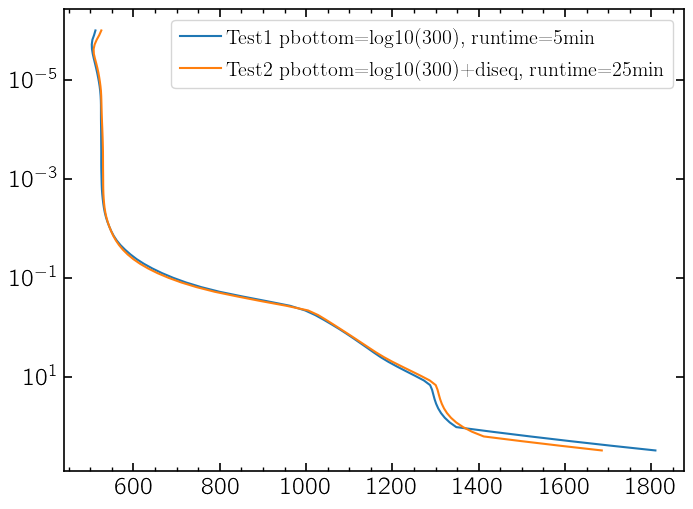

In [9]:
directory = "ReflectXGasGiantModelGrid-Jupiter-Tstar5000-Rstar0.8-Teq624-sep0.1-rad1.0-mass1.0-mh3-co0.5-phase120-Test1"
m1 = pickle.load(open(directory + '/cloud-free-model.pkl','rb'))[1]
directory = "ReflectXGasGiantModelGrid-Jupiter-Tstar5000-Rstar0.8-Teq624-sep0.1-rad1.0-mass1.0-mh3-co0.5-phase120-Test2"
m2 = pickle.load(open(directory + '/cloud-free-model.pkl','rb'))[1]

%matplotlib inline
plt.plot(m1['temperature'],m1['pressure'], label='Test1 pbottom=log10(300), runtime=5min')
plt.plot(m2['temperature'],m2['pressure'], label='Test2 diseq, runtime=25min')
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')
plt.legend(fontsize=15)
